In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import datetime as dt
import geopandas as gpd
import string
import statistics as stat

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Insert path\filename.ext string of the csv file in between the quotes:
DataFilePath = r'FeatureMatrix_3m.csv'

#Data types for relevant columns in the feature matrix:
dtype_dict = {'MoundID': str, 'Active': str, 'Profile': str}

#Get the KnownMounds shapefile:
ShapeFilePath = r'KnownMounds_3857.shp'
Shape = gpd.read_file(ShapeFilePath)
KnownMounds = Shape[Shape.Active != 'Ambiguous Active']

def grabNewFile():
    """
    Read the feature matrix csv and return as a pandas DataFrame
    """
    print('grabNewFile() called. Fresh instance of original file being read...')
    frame = pd.read_csv(DataFilePath,
                      dtype=dtype_dict).drop(['ProbClass', 'LonLat', 'ProbClassInt2', 'Maxp', 'Dist', 'MoundProb'], axis=1)
    return frame

#Read in the feature matrix csv:
data1 = grabNewFile()

grabNewFile() called. Fresh instance of original file being read...


In [3]:
#Ordinal probability classes, from least- to most-likely:
ProbClassCategories = ['UK', 'L', 'M', 'H']

def moundProbClass(num, MaxProb=0.7, MaxDist=10, Break1=0.3, Break2=0.5):
    """
    Return a classification based on the distance the centre of a pixel is from the recorded mound location.
    Requires that a distance field is already included 
    
    Args:
    -A number, which is the euclidean distance (in metres) of a pixel to the closest known mound
    -The maximum probability that the mound is in a given pixel; this will be assigned to the mound's 'home' pixel.
    -The horizontal uncertainty (in metres) of the original GPS measurement. Defaults to 10m. 
    -The value at which the probability class becomes 'M' (defaults to 0.3)
    -The value at which the class becomes 'H' (defaults to 0.5)
    
    Returns:
    -A string representing the classification
    """
    frac = 1 - MaxProb
    
    #Do not calculate for distance values greater than the maximum:
    if num > MaxDist:
        prob = 0
    #Apply a formula for decay as distance from mound increases from 0 to 10 metres
    else:
        prob = math.cos(num*((math.acos(frac))/MaxDist)) - frac
    
    #Convert the numerical results of the previous step to ordinal categories:
    if prob <= 0:
        result = ProbClassCategories[0]
    elif prob < Break1:
        result = ProbClassCategories[1]
    elif prob < Break2:
        result = ProbClassCategories[2]
    else:
        result = ProbClassCategories[3]
    return result


#Class to scalar dictionary for use in future colour mapping (not used in final model):
pcsd = {'UK': -1,
       'L': 0,
       'M': 0.4,
       'H': 0.8}
#Class to integer dictionary (not used in final model):
pcid = {'UK': 0,
       'L': 1,
       'M': 2,
       'H': 3}
#Class to binary dictionary (not used in final model):
pcbd = {'UK': False,
       'L': True,
       'M': True,
       'H': True}

#Apply the moundProbClass function to convert distance to a categorical probability class:
def getCategories(dataframe, distanceField='grid_code'):
    """Calculate a probability class and then store it in several different formats.
    
    Args:
    -A dataframe to input
    -The name of the field which contains the distance (in metres) to the nearest known mound
    
    Returns:
    -A version of the dataframe with four new columns which can be used as target vectors
    
    Notes:
    -this function is called by 
    -moundProbClass is called from here.
    """
    print('getCategories() called. Adding options for target columns...')
    #Calculate the probability class using moundProbClass():
    dataframe['ProbClass'] = dataframe[distanceField].apply(lambda x: moundProbClass(x))
    #Convert to a scalar in case that's useful:
    dataframe['ProbScalar'] = dataframe['ProbClass'].apply(lambda x: pcsd[x])
    #Convert to an integer for each ProbClass category:
    dataframe['ProbInt'] = dataframe['ProbClass'].apply(lambda x: pcid[x])
    #Convert to boolean:
    dataframe['ProbBin'] = dataframe['ProbClass'].apply(lambda x: pcbd[x])
    return dataframe

#For when we need to repeat an operation without getting a new dataset:
StaticDataset = getCategories(grabNewFile())

def activeSelector(df, TargetField, ActiveSubset):
    """Declassify certain mounds based on their activity status
    
    Called by getFMTV() with the same ActiveSubset argument as getFMTV().
    
    Args:
    -The field which contains the target categories
    -The subset of mounds based on activity status, which can be in ['All', 'ActiveOnly', 'ActiveAndAmbiguous']
    
    Returns:
    -The same dataframe but where the mound status doesn't match the desired activity status, the target field is
        given the same value as non-mound pixels.
    """
    print('activeSelector(). Values of {} will be reclassified to non-mound if the activity status is not in {}'.format(\
    TargetField, ActiveSubset))
    if TargetField == 'ProbClass':
        if ActiveSubset == 'ActiveOnly':
            df.loc[df['Active'] != 'Active', 'ProbClass'] = 'UK'
            print('ActiveSelector converted inactive mounds to UK')
        elif ActiveSubset == 'ActiveAndAmbiguous':
            df.loc[df['Active'] == 'Inactive', 'ProbClass'] = 'UK'
        else:
            print('activeSelector() made no changes, either all mounds were selected or an invalid argument was given')
        return df
    elif TargetField == 'ProbScalar':
        if ActiveSubset == 'ActiveOnly':
            df.loc[df['Active'] != 'Active', 'ProbScalar'] = -1
        elif ActiveSubset == 'ActiveAndAmbiguous':
            df.loc[df['Active'] == 'Inactive', 'ProbScalar'] = -1
        else:
            print('activeSelector() made no changes, either all mounds were selected or an invalid argument was given')
        return df
    elif TargetField == 'ProbInt':
        if ActiveSubset == 'ActiveOnly':
            df.loc[df['Active'] != 'Active', 'ProbInt'] = 0
        elif ActiveSubset == 'ActiveAndAmbiguous':
            df.loc[df['Active'] == 'Inactive', 'ProbInt'] = 0
        else:
            print('activeSelector() made no changes, either all mounds were selected or an invalid argument was given')
        return df
    elif TargetField == 'ProbBin':
        if ActiveSubset == 'ActiveOnly':
            df.loc[df['Active'] != 'Active', 'ProbBin'] = False
        elif ActiveSubset == 'ActiveAndAmbiguous':
            df.loc[df['Active'] == 'Inactive', 'ProbBin'] = False
        else:
            print('activeSelector() made no changes, either all mounds were selected or an invalid argument was given')
        return df
    else:
        print('activeSelector() did nothing, TargetField argument was not valid.')
        return None


#Define which columns arepredictor variables:
AllPredictorColumns = ['Index_3m_ARVI_3857',
                   'Index_3m_EVI_3857',
                   'Index_3m_NDVI_3857',
                   'Index_3m_SAVI_3857',
                   'Index_3m_TCT_Bright_3857',
                   'Index_3m_TCT_Green_3857',
                   'Index_3m_TCT_Wet_3857',
                   'PS_3m_B1_CoastalBlue_3857',
                   'PS_3m_B2_Blue_3857',
                   'PS_3m_B3_Green_i_3857',
                   'PS_3m_B4_Green_3857',
                   'PS_3m_B5_Yellow_3857',
                   'PS_3m_B6_Red_3857',
                   'PS_3m_B7_RedEdge_3857',
                   'PS_3m_B8_NIR_3857',
                   'S2_3m_B2_Blue_3857',
                   'S2_3m_B3_Green_3857',
                   'S2_3m_B4_Red_3857',
                   'S2_3m_B5_RE1_3857',
                   'S2_3m_B6_RE2_3857',
                   'S2_3m_B7_RE3_3857',
                   'S2_3m_B8_NIR_3857',
                   'S2_3m_B8A_RE4_3857',
                   'S2_3m_B11_SWIR1_3857',
                   'S2_3m_B12_SWIR2_3857']


#Predictor (X) and Target (Y) for only pixels within 10m of a mound:
def getFMTV(df, TargetField='ProbClass', PredCols=AllPredictorColumns,\
            TrainSubset=20, DistField='grid_code', ActiveSubset='All', SplitMethod='Normal'):
    """Return a feature matrix and target vector that can be used for training a Random Forest Classifier (RFC)
    
    Args:
        -dataframe; including all predictor variables and target class field
        -PredCols; a list of column names. Defaults to all available.
        -TargetField; The name of the field which includes the classes to be predicted
        -TrainSubset; either an integer in metres representing the distance-from-mound cutoff point for pixels to be included.
            Alternatively, this can be the string 'MoundsOnly', or the string 'All'
        -The name of the field which stores the distance values. Defaults to 'grid_code'
        -ActiveSubset; the subset of mounds based on activity status, which can be in 
            ['All', 'ActiveOnly', 'ActiveAndAmbiguous']
        -SplitMethod; this can be in ['Normal', 'StratRand']
        
    Returns:
        -Feature Matrix of all predictor variables for the chosen pixels
        -Target Vector of all the classes for those pixels
        -IF an integer is passed as the TrainSubset argument, an array of MoundIDs will also be returned.
        
    Notes:
        -The GridID field corresponds to which 1x1km square in the study area that pixel corresponds to.
    """
    print('getFMTV() called. Generating Feature Matrix and Target Vector...')
    #Call the activeSelector() function, which will reclassify pixels if they don't meet activity criteria
    if ActiveSubset != 'All':
        dataframe = activeSelector(df, TargetField, ActiveSubset)
    else:
        dataframe = df
        
    #If we only want 'mound' pixels:
    if TrainSubset == 'MoundsOnly':
        #Grab rows where the previously-calculated probclass is not 'UK':
        moundPatches = dataframe.loc[dataframe['ProbClass'] != 'UK']
        #Return just the predictor variables as the feature matrix:
        pred_X_mound = moundPatches[PredCols]
        #Return just the relevant class as the target vector:
        targ_Y_mound = moundPatches[TargetField]
        return pred_X_mound, targ_Y_mound
    elif TrainSubset == 'All':
        #Get all the pixels:
        subset = dataframe
        #Return just the predictor variables as the feature matrix:
        pred_X_all = subset[PredCols]
        #Return just the relevant class as the target vector:
        targ_Y_all = subset[TargetField]
        return pred_X_all, targ_Y_all
    else:
        try:
            #Get pixels where the distance is less than the passed value, as long as it is numeric:
            if SplitMethod == 'StratRand':
                #Drop rows with no MoundID if we're doing stratified random
                subset = dataframe.loc[dataframe[DistField] < TrainSubset].dropna(subset=['MoundID'])
            else:
                #MoundID not important otherwise
                subset = dataframe.loc[dataframe[DistField] < TrainSubset]
            subset.reset_index(drop=True, inplace=True)
            #Return just the predictor variables as the feature matrix:
            pred_X_near = subset[PredCols]
            #Return just the relevant class as the target vector. Force it to be a DataFrame:
            targ_Y_near = pd.DataFrame(data=subset[TargetField]) 
            #Return the GridID for each pixel 
            MoundIds = subset['MoundID']
            return pred_X_near, targ_Y_near, MoundIds
        except TypeError:
            print("TrainSubset must be either a positive number, 'MoundsOnly', or 'All'.")
            return None


grabNewFile() called. Fresh instance of original file being read...
getCategories() called. Adding options for target columns...


In [4]:
class DataStance:
    """
    The purpose of this class is to produce a combined instance of all things needed for an RFC model.
    """
    def __init__(self,
                name,
                ClassField,
                SubsetForTrain='MoundsOnly',
                ActiveSubset='All',
                SplitMethod='Normal',
                TestPortion=0.25,
                PredictorColumns=AllPredictorColumns,
                StratificationClusters=4
                ):
        """Create an analysis environment which can then be compared with others
        """
        print('Creating new DataStance instance...')
        self.name = name
        self.ClassField = ClassField
        self.SubsetForTrain = SubsetForTrain
        self.ActiveSubset = ActiveSubset
        self.SplitMethod = SplitMethod
        self.TestPortion = TestPortion
        self.PredictorColumns = PredictorColumns
        self.StratificationClusters = StratificationClusters
        #Get a fresh copy of the file:
        #self.file = getCategories(grabNewFile())
        #Use the same copy of the file for each instance:
        self.file = StaticDataset
        
        #Split file into a Feature Matrix and Target Vector
            
        ##### PATH 2: Pixels to be split into training/testing datasets independently of which mound they belong to: #####
        #Call FMTV. We don't need the MoundIds so we'll just dump it into a dummy variable:
        self.pred_X, self.targ_Y, garb = getFMTV(self.file,
                                                TargetField=self.ClassField,
                                                TrainSubset=self.SubsetForTrain,
                                                ActiveSubset=self.ActiveSubset,
                                                PredCols=self.PredictorColumns)
        #Split the data into training and testing subsets:
        self.pred_train, self.pred_test, self.targ_pretrain, self.targ_pretest = train_test_split(\
                                                                                                self.pred_X,
                                                                                                self.targ_Y,
                                                                                                test_size=self.TestPortion
                                                                                               )
        self.targ_train = np.ravel(self.targ_pretrain)
        self.targ_test = np.ravel(self.targ_pretest)
        print("Created the '{}' DataStance.".format(self.name))




In [5]:
#Minimum and maximum coordintes, from the 'feature vertices to point' tool in ArcGIS Pro:
vertexCoords = {'MinX': 15877272,
               'MaxX': 15882019,
               'MinY': -4148372,
               'MaxY': -4144533}
Hmargin = 100
Vmargin = 100
mapBounds = [vertexCoords['MinX'] - Hmargin,
            vertexCoords['MaxX'] + Hmargin,
            vertexCoords['MinY'] - Vmargin,
            vertexCoords['MaxY'] + Vmargin]


#Generate arrays for regularly-spaced grid/tick marks:
lonTicks = np.arange(mapBounds[0], mapBounds[1], 1000)[1:]
lonLabels = ['+1km', '+2km', '+3km', '+4km']
latTicks = np.arange(mapBounds[2], mapBounds[3], 1000)[1:]
latLabels = ['+1km', '+2km', '+3km', '+4km']

#Set map width and height (in inches):
map1_width = 12
map1_height = 9
map1_dpi = 300

#Custom colourmaps
#ProbClass:
#This is a very clunky way of doing it. Given category_formatter() converts to an integer anyway,

#Create a colourmap object to use:
pc_cmap = mcolors.ListedColormap(['#ffffff',
                                  '#fee8c8',
                                  '#fdbb84',
                                  '#e34a33'])

pc_categories=ProbClassCategories
pc_bounds=[0, 1, 2, 3, 4]

#Create a colourmap index.
#This is used by the 'ticks' element of the 'legend_kwds' argument.
#NOT CURRENTLY USED
# pc_norm=mcolors.BoundaryNorm(boundaries=pc_bounds, #The boundaries of the bins into which colours will be assigned
#                              ncolors=pc_cmap.N #The number of colours, which here is 4
#                             )

# Define a safe formatter function to avoid index errors
def category_formatter(x, pos):
    """Define a safe formatter function to avoid index errors.
    The function should take in two inputs (a tick value x and a position pos), 
    and return a string containing the corresponding tick label.
    This is currently used by the map output generation and may not be necessary.
    """
    if 0 <= int(x) < len(pc_categories):
        return pc_categories[int(x)]
    else:
        return ''

class ProjectMap:
    def __init__(self, name):
        """Set all the parameters which should be common to any maps produced here as output.
        """
        print('Creating new ProjectMap instance...')
        self.name = name
        #Create a figure and axis to use for plotting this map's data:
        self.fig, self.ax = plt.subplots()
        
        #Set the maps visual attributes for the screen:
        self.fig.set_size_inches((map1_width, map1_height))
        self.fig.set_dpi(map1_dpi)
        
        #Set the map bounds:
        self.ax.set_xlim((mapBounds[0], mapBounds[1]))
        self.ax.set_ylim((mapBounds[2], mapBounds[3]))
        
        #Set the grid:
        plt.grid(visible=True,
                 alpha=0.5
                )
        
        #Set the tick interval and labels:
        plt.xticks(ticks=lonTicks,
                  labels=lonLabels)
        plt.yticks(ticks=latTicks,
                   labels=latLabels)
        
        #Set where the ticks show and which ones are labelled:
        plt.tick_params(axis='both',
                        direction='out',
                        left=True,
                        labelleft=True,
                        right=False,
                        labelright=False,
                        top=False,
                        labeltop=False,
                        bottom=True,
                        labelbottom=True
                        )
        print("Created the '{}' ProjectMap.".format(self.name))
        
    def PredSur(self, dataframe, mapCol, predColType):
        """Draw the current prediction on the current axis.
        X column MUST be called WebMerc_X
        Y column MUST be called WebMerc_Y
        """
        print("PredSur method of ProjectMap object {} called. Plotting prediction surface...".format(self.name))
        #Create a Geodataframe which can then be plotted:
        self.GDF = gpd.GeoDataFrame(data=dataframe,
                        geometry=gpd.points_from_xy(dataframe.WebMerc_X, dataframe.WebMerc_Y),
                        crs='EPSG:3857')
        #If using ProbClass as the target field, convert it to a category index.
        if predColType == 'ProbClass':
            #Convert Probclass to integers; 0, 1, 2, 3 for UK, L, M, H respectively:
            self.GDF['CatIndex'] = self.GDF['Prediction'].apply(lambda x: pc_categories.index(x))
            mapCol = 'CatIndex'
            cmapToUse = pc_cmap
            legend_kwds={
                
            }
        #Placeholder colourmap for other target field types:
        else:
            cmap = 'Dark2'
            legend_kwds={
                
            }
        #Plot the geodataframe created by this method on the current instance of the class:
        self.GDF.plot(ax=self.ax,
                column=self.GDF[mapCol],
                marker='.',
                cmap=cmapToUse,
                markersize=1,
                legend=True,
                legend_kwds=legend_kwds)
        plt.title(self.name)
        
    def ShowKnown(self, ActiveSubset='All', SplitMethod='Normal', TrainMounds=None, TestMounds=None):
        print("Adding known mound locations to plot...")
        
        #If split method is StratRand, we need to format the colour and shape of the mounds
        #    based on whether they were included in the training data or not.
        if SplitMethod == 'StratRand' and ActiveSubset == 'ActiveOnly':
            #Build a dictionary of MoundIDs and their class
            TypeDict = {}
            for a in TrainMounds:
                TypeDict[a] = 'Training'
            for b in TestMounds:
                TypeDict[b] = 'Test'
            
            #Get a local instance of the known mounds shapefile, and map a column with the split so we can change styling:
            MoundsToMap = KnownMounds.loc[KnownMounds['Active'] == 'Active']
            MoundsToMap['Split'] = [TypeDict[a] for a in MoundsToMap['MoundID']]
            TrainingMounds = MoundsToMap.loc[MoundsToMap['Split'] == 'Training']
            TestingMounds = MoundsToMap.loc[MoundsToMap['Split'] == 'Test']
            
            TrainingMounds.plot(ax=self.ax,
                            marker='s',
                            facecolors='none',
                            edgecolors='green',
                            linewidth=0.5)
            TestingMounds.plot(ax=self.ax,
                              marker='o',
                              facecolors='none',
                              edgecolors='blue',
                              linewidth=0.5)
        
        #If we're doing stratified random on all mounds:
        elif SplitMethod == 'StratRand':
            #Build a dictionary of MoundIDs and their class
            TypeDict = {}
            for a in TrainMounds:
                TypeDict[a] = 'Training'
            for b in TestMounds:
                TypeDict[b] = 'Test'
            
            #Get a local instance of the known mounds shapefile, and map a column with the split so we can change styling:
            MoundsToMap = KnownMounds
            MoundsToMap['Split'] = [TypeDict[a] for a in MoundsToMap['MoundID']]
            
            TrainingMounds = MoundsToMap.loc[MoundsToMap['Split'] == 'Training']
            TestingMounds = MoundsToMap.loc[MoundsToMap['Split'] == 'Test']
            
            TrainingActive = TrainingMounds.loc[TrainingMounds['Active'] == 'Active']
            TrainingInactive = TrainingMounds.loc[TrainingMounds['Active'] == 'Inactive']
            TestingActive = TestingMounds.loc[TestingMounds['Active'] == 'Active']
            TestingInactive = TestingMounds.loc[TestingMounds['Active'] == 'Inactive']
            
            layers = [TrainingActive, TrainingInactive, TestingActive, TestingInactive]
            markers = ['s', 's', 'o', 'o']
            edgecolors = ['blue', 'grey', 'blue', 'grey']
            for i in range(0, 4):
                layers[i].plot(ax=self.ax,
                              marker=markers[i],
                              facecolors='none',
                              edgecolors=edgecolors[i],
                              linewidth=0.5)
                
                
            
        
        elif ActiveSubset == 'ActiveOnly':
            MoundsToMap = KnownMounds.loc[KnownMounds['Active'] == 'Active']
            MoundsToMap.plot(ax=self.ax,
                            marker='o',
                            facecolors='none',
                            edgecolors='blue',
                            #mfc=(0, 0, 0, 0),
                            linewidth=0.5)
        else:
            KnownMounds.plot(ax=self.ax,
                            marker='o',
                            facecolors='none',
                            edgecolors='blue',
                            #mfc=(0, 0, 0, 0),
                            linewidth=0.5)


In [6]:
def TuneNumTrees(DS_instance, maxTrees=150):
    """Test a range of values for several key Random Forest Classifier hyperparameters and plot the impact of each.
    
    Args:
    -A valid instance of the DataStance class
    -The maximum number of trees to try with (int)
    
    Returns:
    -A Pandas Series containing the number of trees as the index and the corresponding accuracy as the data.
    
    Notes:
    -Also plots a line chart.
    """
    print("TuneNumTrees() called on '{}'. Testing performance on testing data with different numbers of trees."\
          .format(DS_instance.name))
    #List of tree numbers to try:
    NumTreesRange = [1] + [a for a in range(10, maxTrees+1, 20)]
    #Empty list to append the average scores over 10 runs for each number of trees:
    Scores = []
    for num in NumTreesRange:
        print(f'Testing with {num} trees...')
        #Empty list to append the scores for each run of the current number of trees:
        IndScores = []
        for i in range(0, 10):
            print(f'Test {i+1} of 10...')
            #Create instance of RFC with the current number in NumTreesRange
            thisRFC = RandomForestClassifier(n_estimators=num)
            #Fit the model using the training portion from the datastance input
            thisRFC.fit(DS_instance.pred_train, DS_instance.targ_train)
            #Score the model's accuracy using the testing portion:
            score = thisRFC.score(DS_instance.pred_test, DS_instance.targ_test)
            IndScores.append(score)
            
        print('These are the scores:\n')
        print(IndScores)
        CurrAv = stat.mean(IndScores)
        print(f'\nAverage accuracy with {num} trees was {CurrAv}.\n')
        Scores.append(CurrAv)
    print(Scores)
    fig, ax = plt.subplots()
    plt.title('Tuning Results for Number of Trees')
    plt.suptitle(DS_instance.name)
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy Score')
    ax.plot(NumTreesRange, Scores,
            figure=fig,
            )
    result = pd.Series(data=Scores, index=NumTreesRange)
    return result



def NewModel(DS_instance, NumTrees=100):
    """Train a new Random Forest Classifier Model and test it.
    
    Args:
    -A valid instance of the DataStance class, defined earlier in this code
    
    Returns:
    -A trained model which can then be used to predict values for the entire set of pixels
    -A score for how well the trained model peformed on the testing portion
    -The time it took to train the model
    -The time it took to test
    
    Notes:
    -Parameters such as the train/test split proportions are set when creating the datastance object. All this does
    is give you an instance of the trained model
    -It also prints the start time and end time for training and testing the model, as well as the accuracy 
    """
    print("NewModel() called on '{}'. Training a new Random Forest Classifier using {} of pixels."\
          .format(DS_instance.name, (1 - DS_instance.TestPortion))
    #Create a Random Forest Classifier instance
    rfc = RandomForestClassifier(n_estimators=NumTrees)
    
    #Fit the model based on the training portion defined by the DataStance:
    start1 = dt.datetime.now()
    print('Starting training at {}.'.format(start1))
    rfc.fit(DS_instance.pred_train, DS_instance.targ_train)
    end1 = dt.datetime.now()
    TrainTime = end1 - start1
    print('Finished at {}. Training the model took {}.'.format(end1, TrainTime))
    
    #Test the model on the testing portion defined by the DataStance:
    start2 = dt.datetime.now()
    print('Starting testing at: {}'.format(start2))
    TestScore = rfc.score(DS_instance.pred_test, DS_instance.targ_test)
    end2 = dt.datetime.now()
    TestTime = end2 - start2
    print('Finished test at {}. Testing took {}'.format(end2, TestTime))
    print('Model accuracy on initial test was {}'.format(TestScore))
    
    return rfc, TestScore, TrainTime, TestTime


def predictor(TrainedRFC, DS_instance):
    """Use a trained RFC model to predict classes across the whole dataset
    
    Args:
    -An instance of the SciKit-learn RandomForestClassifier class which has been trained.
    -An instance of the DataStance class (defined above) which stores some of the parameters used to train the model
    
    Returns:
    -A map which shows the prediction surface.
    
    Notes:
    -It's important that it calls getFMTV with ActiveSubset='All' specified. Because we want to predict for every
    pixel, not just the active mounds.
    """
    print("predictor() called. Making predictions for all pixels...")
    #Get a fresh instance of the orginal dataset:
    FreshFile = getCategories(grabNewFile())
    
    #Get a Featire Matrix and Targtet Vector from the original file:
    pred_X, targ_Y = getFMTV(FreshFile,
                        TargetField=DS_instance.ClassField,
                        TrainSubset='All',
                        ActiveSubset='All',
                        PredCols=DS_instance.PredictorColumns)
    
    #Use the trained model to predict classes for all pixels in the dataset:
    start1 = dt.datetime.now()
    print('Starting prediction at {}.'.format(start1))
    predict = TrainedRFC.predict(pred_X)
    end1 = dt.datetime.now()
    dur1 = end1 - start1
    print('Finished at {}. Predicting classes for all pixels took {}.'.format(end1, dur1))
    
    #Attach the array of predicted values to the dataframe with predictor variables and known classes
    FreshFile['Prediction'] = predict
    
    #ToDo: Compare the new prediction column with the original ProbClass column and generate an accuracy metric
    FreshFile['Match'] = np.where(FreshFile[DS_instance.ClassField] == FreshFile['Prediction'], 1, 0)
    score = FreshFile['Match'].sum() / FreshFile['Match'].count()
    print('Model accuracy on entire dataset: {}'.format(score))
    CurrMap = ProjectMap(DS_instance.name)
    CurrMap.PredSur(FreshFile, mapCol='Prediction', predColType=DS_instance.ClassField)
    return CurrMap


Creating new DataStance instance...
getFMTV() called. Generating Feature Matrix and Target Vector...
activeSelector(). Values of ProbClass will be reclassified to non-mound if the activity status is not in ActiveOnly
ActiveSelector converted inactive mounds to UK
Created the 'Active Mound Prediction with Planetscope Bands Included' DataStance.
NewModel() called on 'Active Mound Prediction with Planetscope Bands Included'. Training a new Random Forest Classifier using 0.5 of pixels.
Starting training at 2024-09-16 12:55:58.095855.
Finished at 2024-09-16 12:55:58.332138. Training the model took 0:00:00.236283.
Starting testing at: 2024-09-16 12:55:58.332138
Finished test at 2024-09-16 12:55:58.345814. Testing took 0:00:00.013676
Model accuracy on initial test was 0.9355608591885441
predictor() called. Making predictions for all pixels...
grabNewFile() called. Fresh instance of original file being read...
getCategories() called. Adding options for target columns...
getFMTV() called. Gener

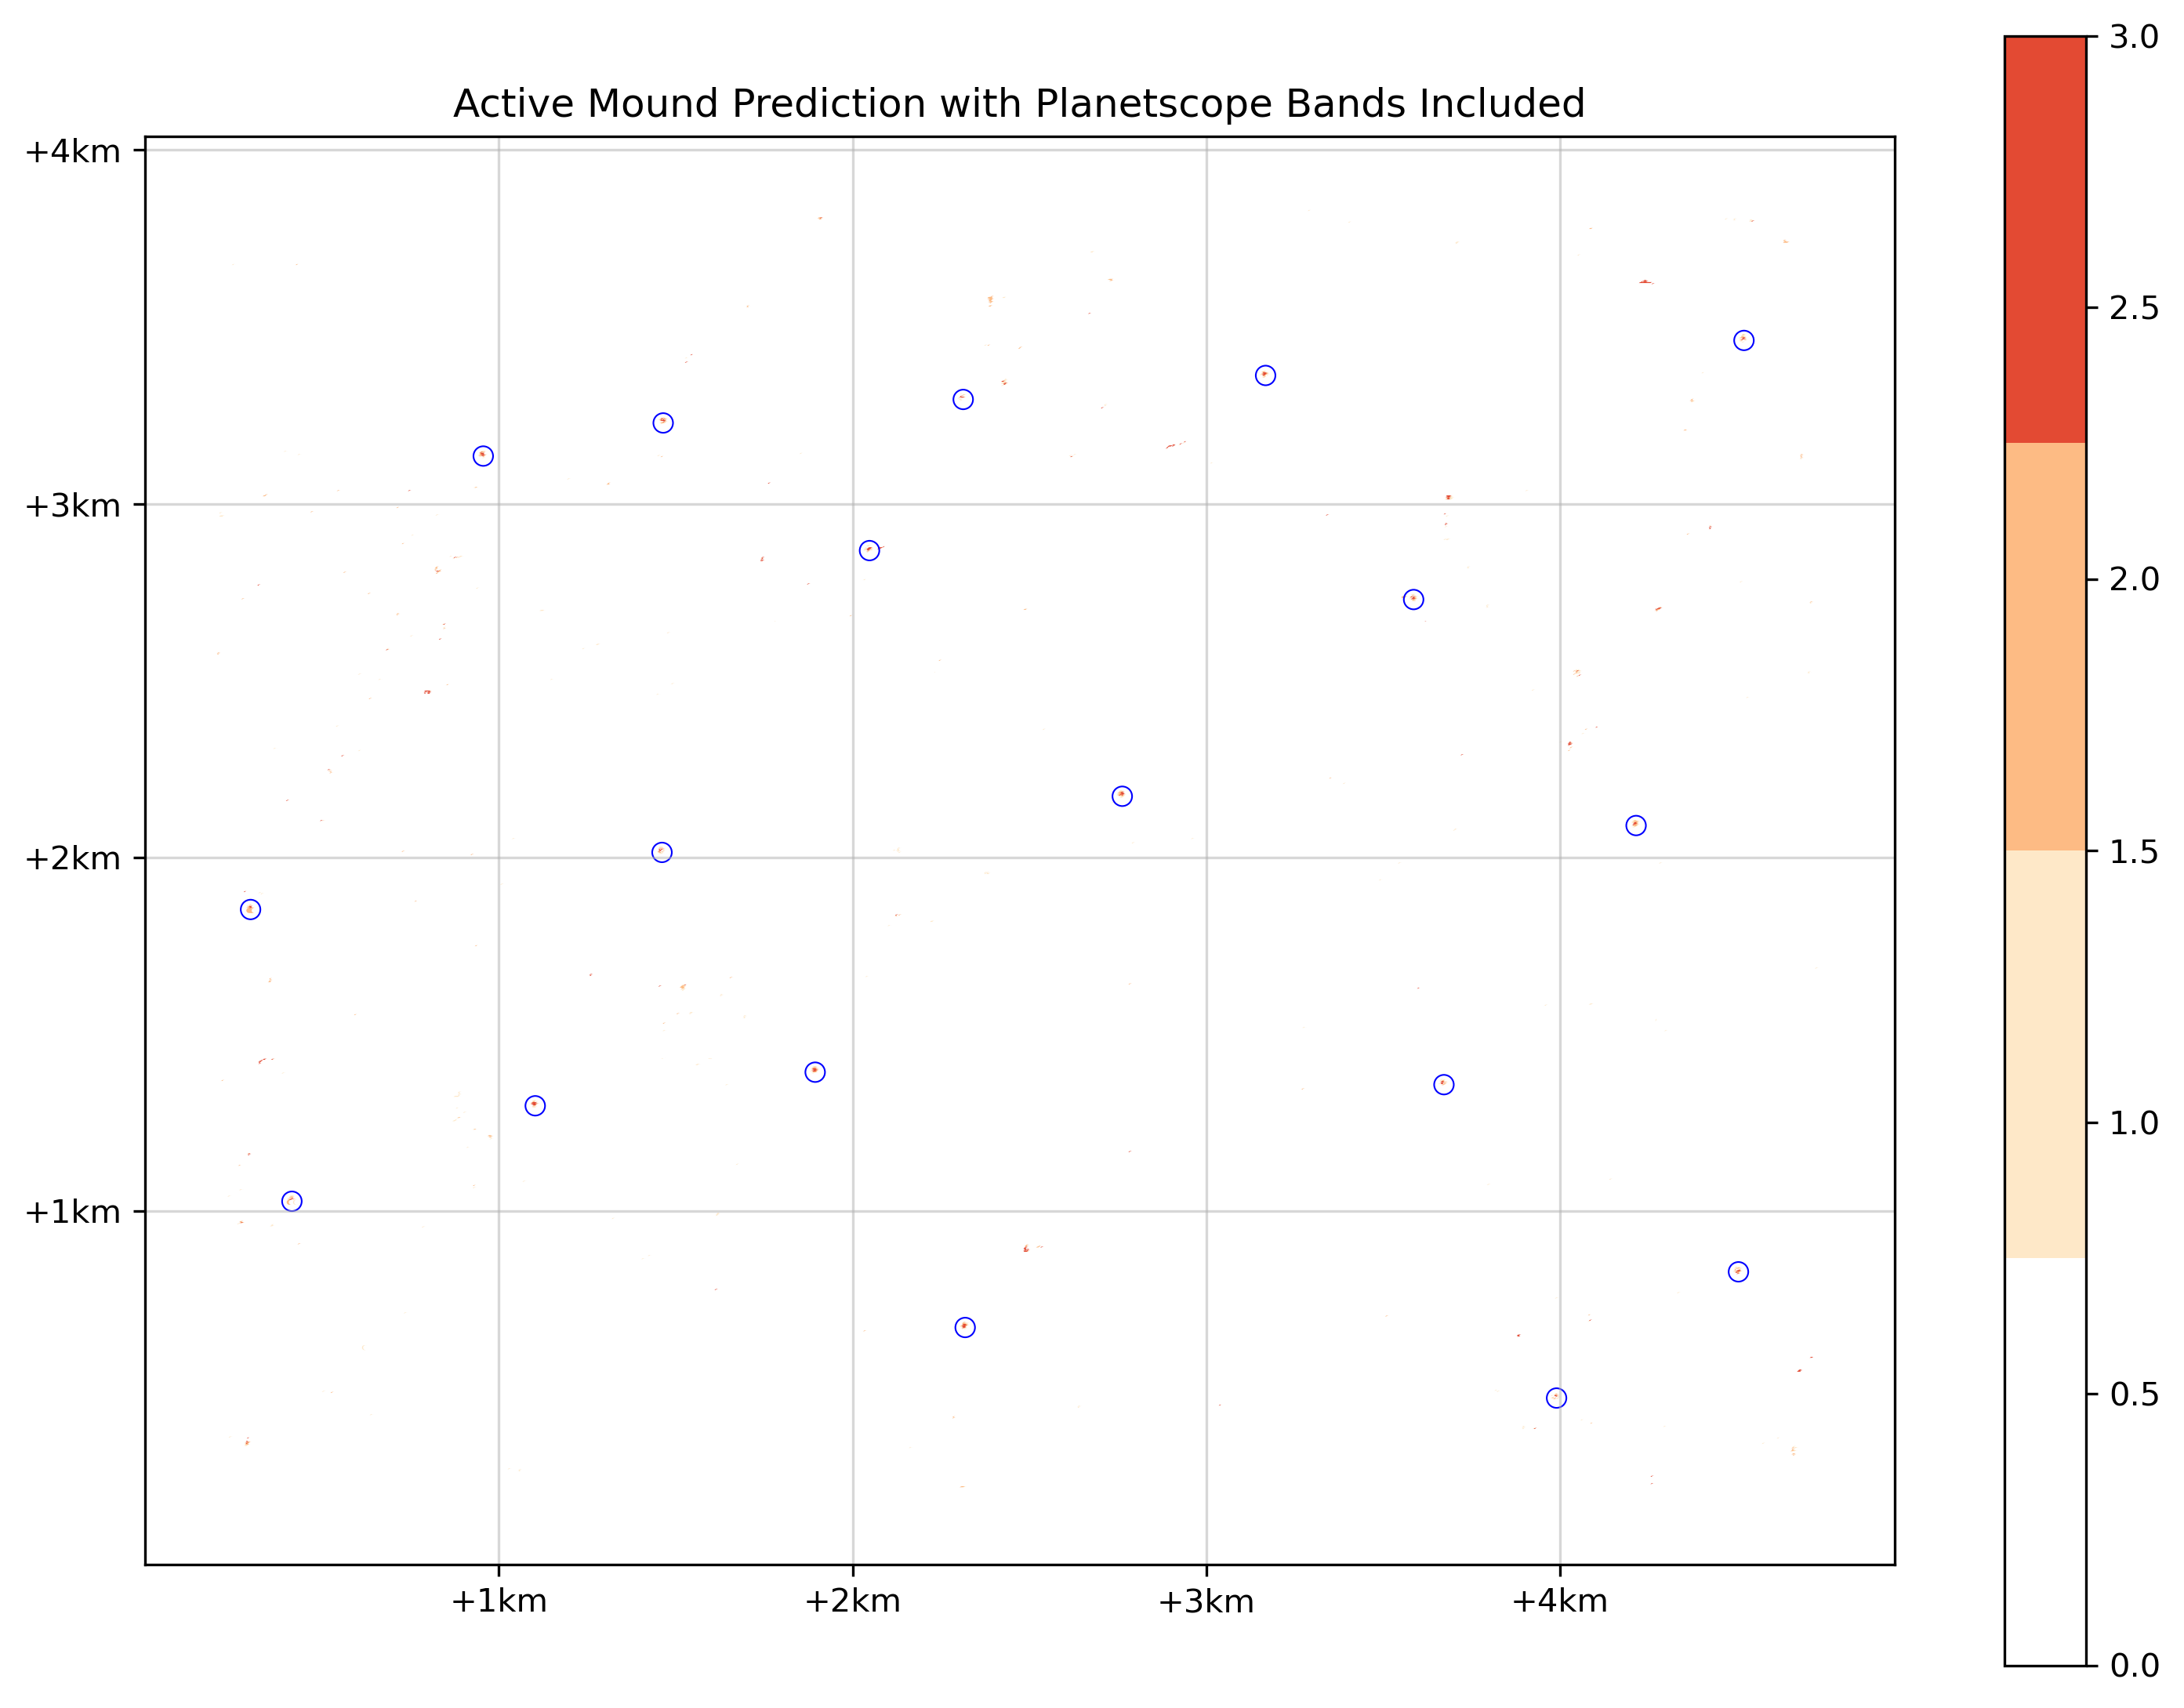

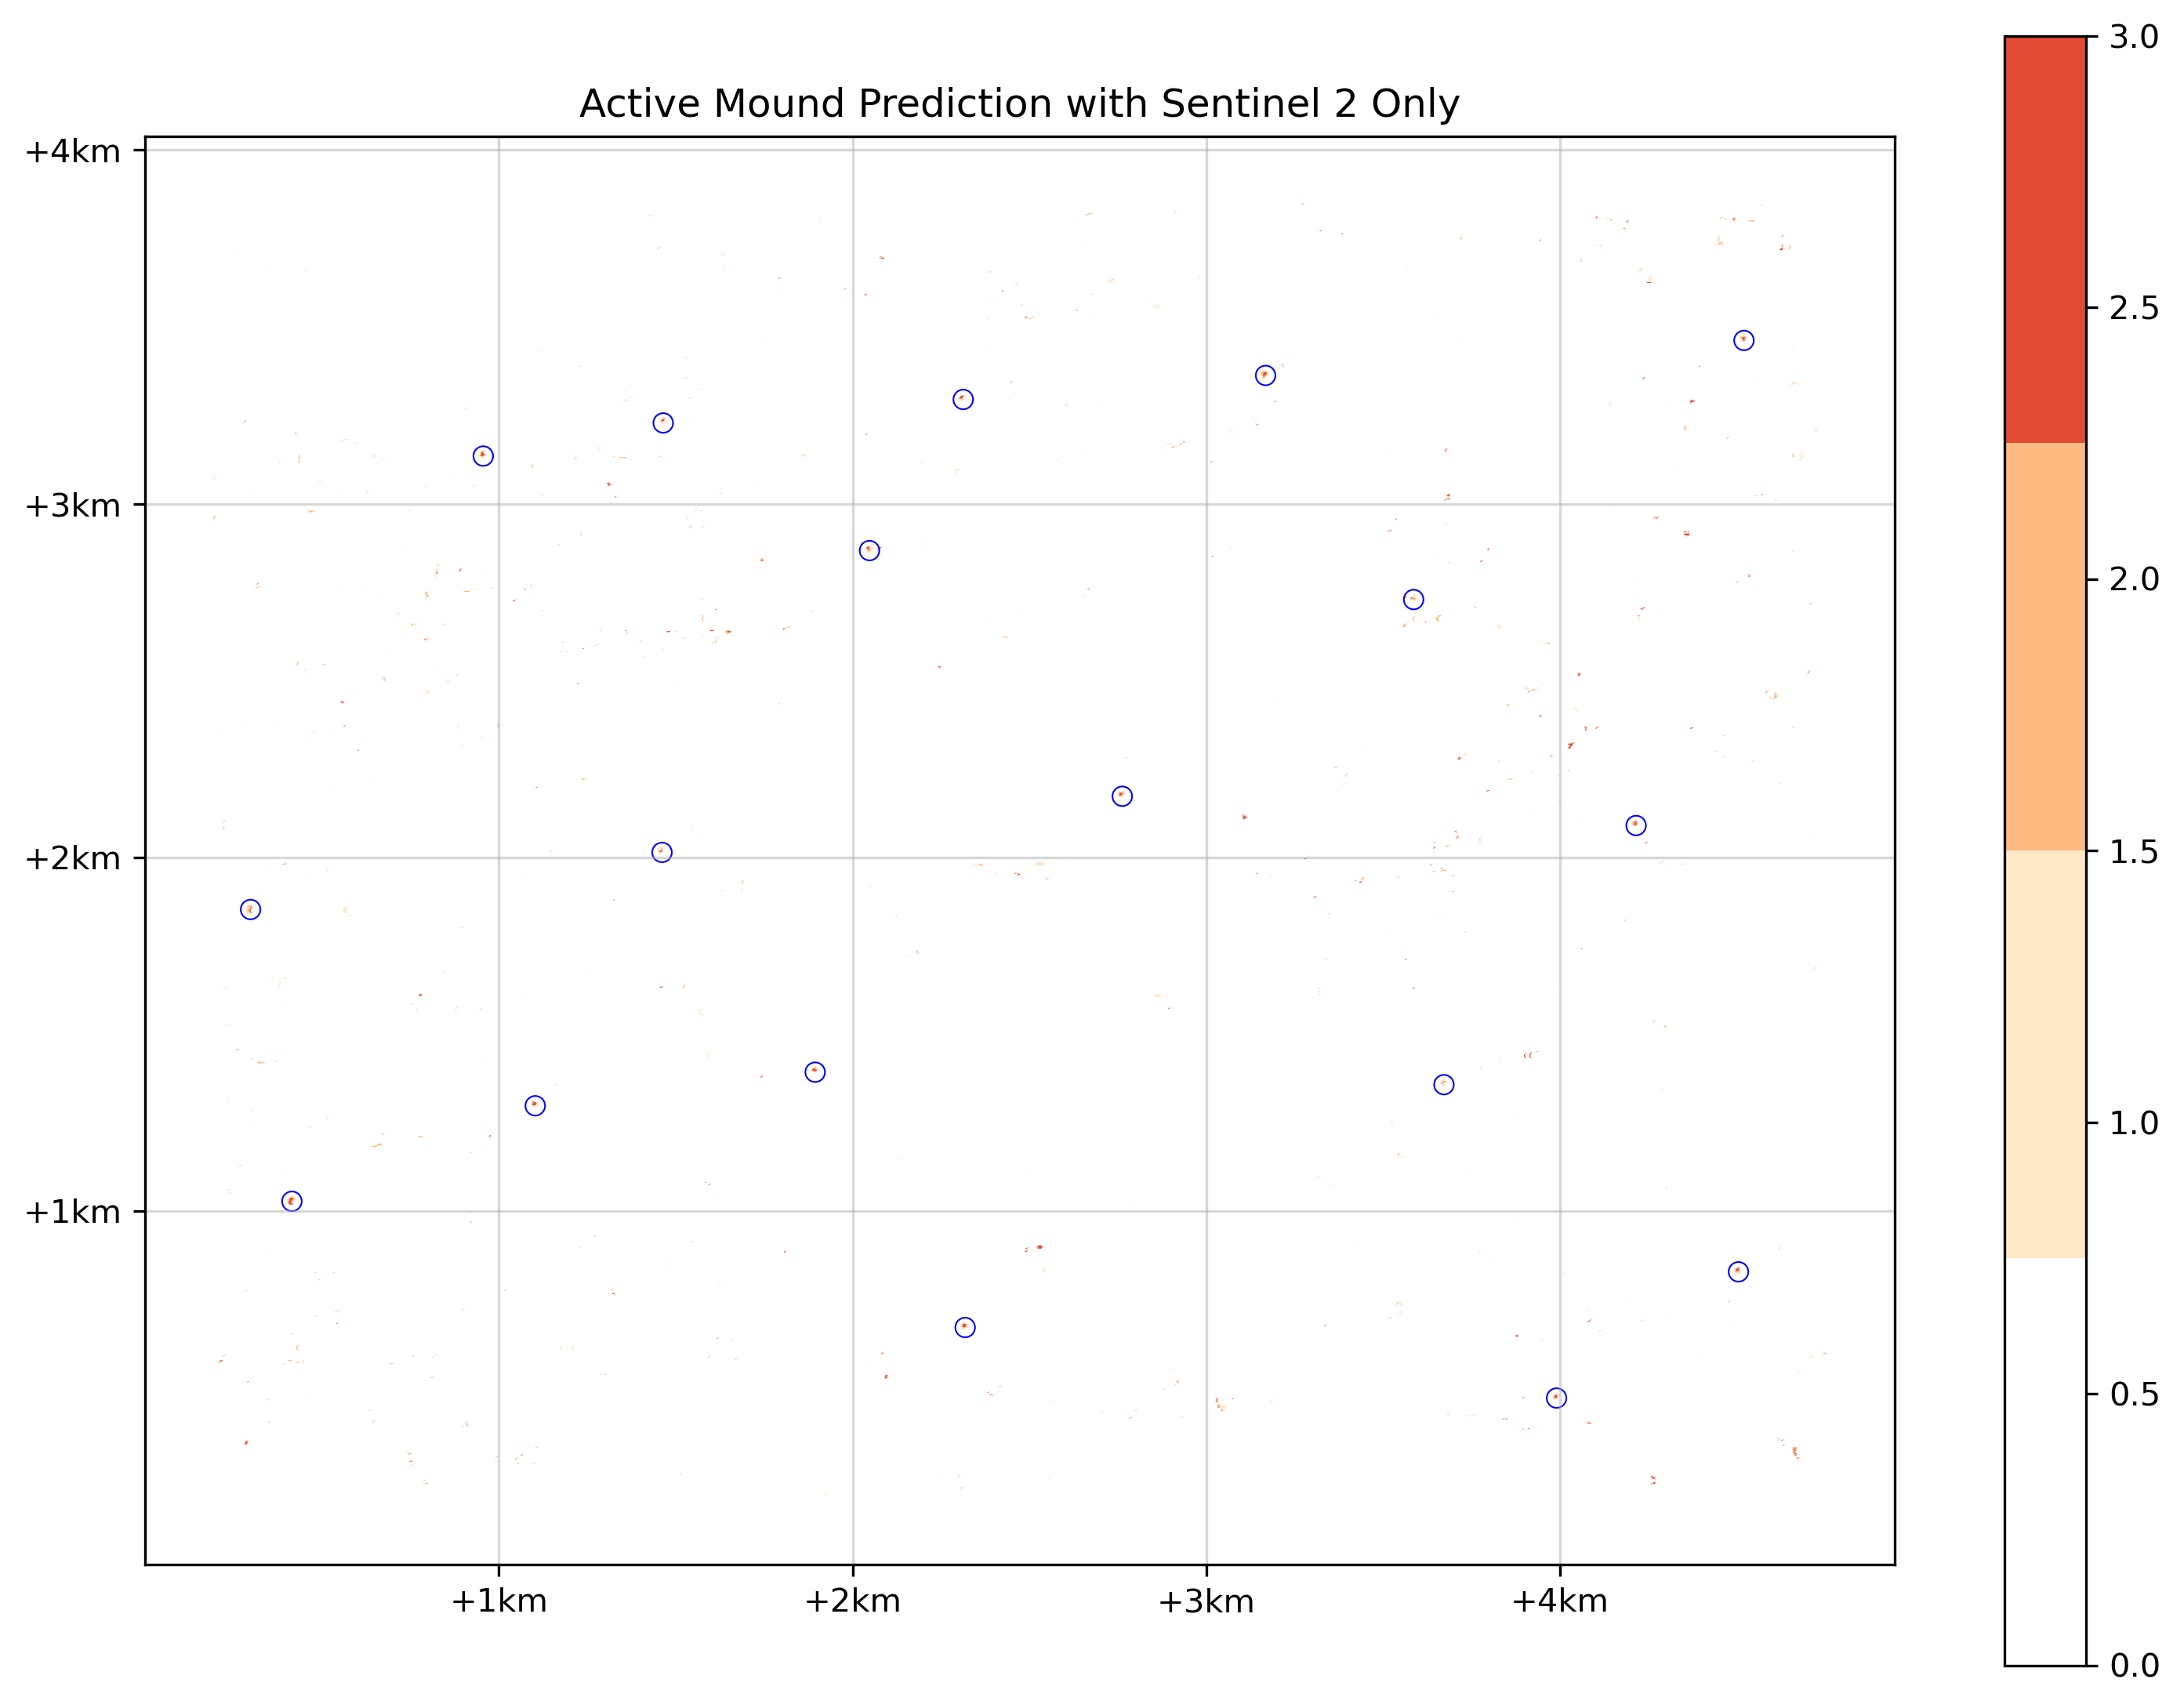

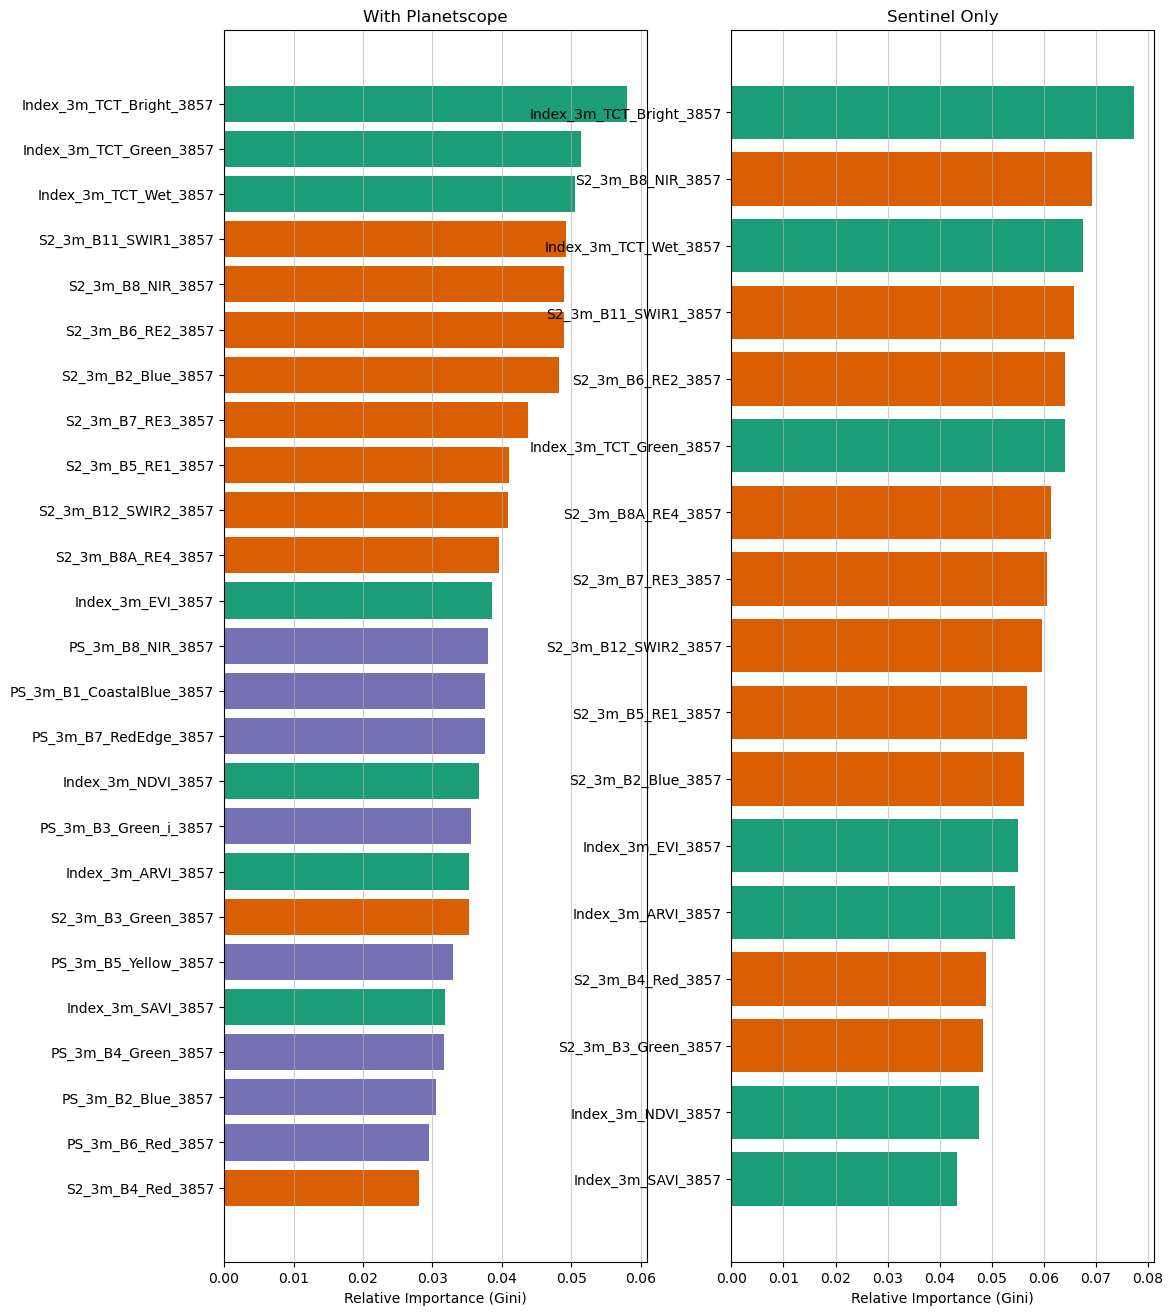

In [8]:


#Dictionary for Feature Importance symbolisation:
TypeDict = {
    'Index': ('Index (from Sentinel 2)', '#1b9e77'),
    'S2': ('Sentinel 2 Band', '#d95f02'),
    'PS': ('Planetscope Band', '#7570b3')
}

#List of predictor columsn excluding Planetscope bands:
NoPlanetCols = ['Index_3m_ARVI_3857',
            'Index_3m_EVI_3857',
            'Index_3m_NDVI_3857',
            'Index_3m_SAVI_3857',
            'Index_3m_TCT_Bright_3857',
            'Index_3m_TCT_Green_3857',
            'Index_3m_TCT_Wet_3857',
            'S2_3m_B2_Blue_3857',
            'S2_3m_B3_Green_3857',
            'S2_3m_B4_Red_3857',
            'S2_3m_B5_RE1_3857',
            'S2_3m_B6_RE2_3857',
            'S2_3m_B7_RE3_3857',
            'S2_3m_B8_NIR_3857',
            'S2_3m_B8A_RE4_3857',
            'S2_3m_B11_SWIR1_3857',
            'S2_3m_B12_SWIR2_3857']

#        ********** Creating model with both satellites (Sentinel 2 and Planetscope) **********

#Datasets ready for model fitting:
Data_BothSats = DataStance(name='Active Mound Prediction with Planetscope Bands Included',
                           ClassField='ProbClass',
                           SubsetForTrain=20, #Distance from mounds for which we can assume 'absence' of other mounds.
                           ActiveSubset='ActiveOnly',
                           TestPortion=0.50,
                           PredictorColumns=AllPredictorColumns)

#Train model:
BothSats_RFC, BothSats_Score, BothSats_TrTi, BothSats_TeTi = NewModel(Data_BothSats,
                                                                      NumTrees=30)
#Make prediction and plot map of prediction surface:
BothSats_map = predictor(BothSats_RFC, Data_BothSats)
#Add known mounds to map:
BothSats_map.ShowKnown(ActiveSubset=Data_BothSats.ActiveSubset,
                       SplitMethod=Data_BothSats.SplitMethod) 

#Get list of predictor variable names, assign them to types and colours, and attach the feature importances:
PredVars2Both = np.array(Data_BothSats.pred_X.columns)
PredType2Both = [TypeDict[b][0] for b in [a.partition('_')[0] for a in PredVars2Both]]
PredColour2Both = [TypeDict[b][1] for b in [a.partition('_')[0] for a in PredVars2Both]]
FeatImps2Both = np.array(BothSats_RFC.feature_importances_)

#Filling out table for easy plotting:
BarTableBoth = pd.DataFrame()
BarTableBoth['Predictor'] = PredVars2Both
BarTableBoth['Importance'] = FeatImps2Both
BarTableBoth['Type'] = PredType2Both
BarTableBoth['Colour'] = PredColour2Both

#Sort for presentation in bar table:
BarTable2Both = BarTableBoth.sort_values('Importance', ascending=True)

BarTable2Both.to_excel(r'FeatImpsBothSats.xlsx')

#        ********** Creating model with Sentinel 2 only **********

#Get dataset ready for model fitting:
Data_NoPS = DataStance(name='Active Mound Prediction with Sentinel 2 Only',
                       ClassField='ProbClass',
                       SubsetForTrain=20,
                       ActiveSubset='ActiveOnly',
                       TestPortion=0.50,
                       PredictorColumns=NoPlanetCols)

#Train model:
NoPS_RFC, NoPS_Score, NoPS_TrTi, NoPS_TeTi = NewModel(Data_NoPS,
                                                      NumTrees=30)

#Make prediction and plot map of prediction surface:
NoPS_map = predictor(NoPS_RFC, Data_NoPS)
#Add known mounds to map:
NoPS_map.ShowKnown(ActiveSubset=Data_NoPS.ActiveSubset,
                   SplitMethod=Data_NoPS.SplitMethod)

#Get list of predictor variable names, assign them to types and colours, and attach the feature importances:
PredVars2NoPS = np.array(Data_NoPS.pred_X.columns)
PredType2NoPS = [TypeDict[b][0] for b in [a.partition('_')[0] for a in PredVars2NoPS]]
PredColour2NoPS = [TypeDict[b][1] for b in [a.partition('_')[0] for a in PredVars2NoPS]]
FeatImps2NoPS = np.array(NoPS_RFC.feature_importances_)

#Filling out table for easy plotting:
BarTableNoPS = pd.DataFrame()
BarTableNoPS['Predictor'] = PredVars2NoPS
BarTableNoPS['Importance'] = FeatImps2NoPS
BarTableNoPS['Type'] = PredType2NoPS
BarTableNoPS['Colour'] = PredColour2NoPS

#Sort for presentation in bar table:
BarTable2NoPS = BarTableNoPS.sort_values('Importance', ascending=True)

BarTable2NoPS.to_excel(r'FeatImpsNoPlanetscope.xlsx')


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 16)
ax1.barh(BarTable2Both['Predictor'], BarTable2Both['Importance'],
        color=BarTable2Both['Colour'])
ax1.set_xlabel('Relative Importance (Gini)')
ax1.set_title('With Planetscope')
ax1.grid(visible=True,
       axis='x',
       alpha=0.6)
ax2.barh(BarTable2NoPS['Predictor'], BarTable2NoPS['Importance'],
        color=BarTable2NoPS['Colour'])
ax2.set_xlabel('Relative Importance (Gini)')
ax2.set_title('Sentinel Only')
ax2.grid(visible=True,
       axis='x',
       alpha=0.6)

plt.show()

In [15]:

#Get a fresh instance of the orginal dataset:
FreshFile = getCategories(grabNewFile())
    
#Get a Feature Matrix and Target Vector from the original file:
pred_X, targ_Y = getFMTV(FreshFile,
                        TargetField='ProbClass',
                        TrainSubset='All',
                        ActiveSubset='All',
                        PredCols=NoPlanetCols)
    
#Use the 'No Planetscope' model to predict classes for all pixels in the dataset:
start1 = dt.datetime.now()
predict = NoPS_RFC.predict(pred_X)
end1 = dt.datetime.now()
dur1 = end1 - start1

#Append the predictor column back on to the orignal file
FreshFile['Prediction'] = predict
#Export to CSV:
FreshFile.to_csv(r'BestModelOutput.csv')




grabNewFile() called. Fresh instance of original file being read...
getCategories() called. Adding options for target columns...
getFMTV() called. Generating Feature Matrix and Target Vector...


In [15]:
PreConf = pd.read_csv(r'BestModelOutput.csv',
                     usecols=['Active', 'ProbClass', 'Prediction'],
                     dtype=str)
PreConf2 = activeSelector(PreConf, 'ProbClass', 'ActiveOnly')
Actual = pd.Series(PreConf2['ProbClass'])
Predicted = pd.Series(PreConf2['Prediction'])
ConfMat = pd.crosstab(Actual, Predicted)
display(ConfMat)
ConfMat.to_excel(r'ConfusionMatrix.xlsx')

activeSelector(). Values of ProbClass will be reclassified to non-mound if the activity status is not in ActiveOnly
ActiveSelector converted inactive mounds to UK


Prediction,H,L,M,UK
ProbClass,,,,
H,109,2,24,27
L,4,143,16,125
M,18,28,113,57
UK,496,512,971,1840510
